In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from imblearn.over_sampling import SMOTE

In [35]:
data_path = "/Users/omaraguilarjr/Library/CloudStorage/OneDrive-GeorgiaInstituteofTechnology/Kaggle/titanic/"

train_df = pd.read_csv(data_path + "train.csv")
test_df = pd.read_csv(data_path + "test.csv")

In [36]:
def encode_data(df):
    df["Sex"] = df["Sex"].map({"male": 0, "female": 1})
    df["Embarked"] = df["Embarked"].map({"C": 0, "Q": 1, "S": 2})
    return df

train_df = encode_data(train_df)
test_df = encode_data(test_df)

all_features = ["Pclass", "Age", "Fare", "Sex", "SibSp", "Parch", "Embarked"]

X_selected = train_df[all_features]
imputer = SimpleImputer(strategy="median")
X_selected = imputer.fit_transform(X_selected)
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)
y = train_df["Survived"]

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_selected, y)

In [37]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(kernel="linear", probability=True),
    "MLP": MLPClassifier(max_iter=1000, random_state=42)
}

# Dictionary to store best hyperparameters for each model
tuned_models = {}

tqdm_desc = "Tuning Hyperparameters for Models"
for model_name, model in tqdm(models.items(), desc=tqdm_desc):
    # Define hyperparameter grid
    param_grid = {
        "RandomForest": {"n_estimators": [50, 100, 200], "max_depth": [None, 10, 20]},
        "GradientBoosting": {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 0.2]},
        "SVM": {"C": [0.1, 1, 10]},
        "MLP": {"hidden_layer_sizes": [(50,), (100,), (50,50)], "alpha": [0.0001, 0.001, 0.01]}
    }
    
    if model_name in param_grid:
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        grid_search = GridSearchCV(model, param_grid[model_name], cv=skf, scoring="accuracy", n_jobs=-1)
        grid_search.fit(X_resampled, y_resampled)
        tuned_models[model_name] = grid_search.best_estimator_
    else:
        tuned_models[model_name] = model

Tuning Hyperparameters for Models:  80%|████████  | 4/5 [00:10<00:02,  2.07s/it]/opt/anaconda3/envs/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and 

In [38]:
# Evaluate tuned models
results = []
for model_name, model in tqdm(tuned_models.items(), desc="Feature Selection and Model Training"):
    sfs = SequentialFeatureSelector(model, n_features_to_select="auto", direction="forward", cv=5, scoring="accuracy", n_jobs=-1)
    sfs.fit(X_resampled, y_resampled)
    selected_features = list(np.array(all_features)[sfs.get_support()])
    
    # Stratified K-Fold Cross Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_resampled[:, sfs.get_support()], y_resampled, cv=skf, scoring="accuracy")
    avg_score = np.mean(scores)
    
    results.append({"Model": model_name, "Features": selected_features, "Accuracy": avg_score})

results_df = pd.DataFrame(results)

# Sort by accuracy
results_df = results_df.sort_values(by="Accuracy", ascending=False)

# Save results
results_df.to_csv("../results/model_feature_results.csv", index=False)

Feature Selection and Model Training: 100%|██████████| 5/5 [00:26<00:00,  5.38s/it]


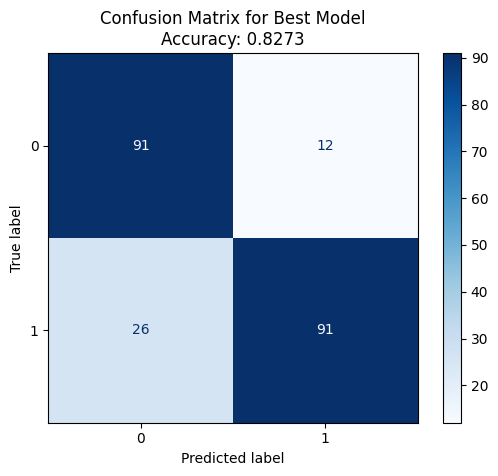

In [39]:
best_model_name = results_df.iloc[0]["Model"]
best_features = results_df.iloc[0]["Features"]
best_model = tuned_models[best_model_name]

# Prepare training data
X_train, X_valid, y_train, y_valid = train_test_split(X_resampled[:, sfs.get_support()], y_resampled, test_size=0.2, random_state=42)

# Fit best model and generate confusion matrix
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred)
conf_matrix = confusion_matrix(y_valid, y_pred)
ConfusionMatrixDisplay(conf_matrix).plot(cmap="Blues")
plt.title(f"Confusion Matrix for Best Model\nAccuracy: {accuracy:.4f}")
plt.show()

In [40]:
X_test = test_df[best_features]
X_test = imputer.transform(X_test)
X_test = scaler.transform(X_test)

# Make predictions
test_predictions = best_model.predict(X_test)

# Create submission file
submission = pd.DataFrame({"PassengerId": test_df["PassengerId"], "Survived": test_predictions})
submission.to_csv("../results/submission.csv", index=False)
print("Submission file saved as submission.csv")

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- Embarked
- Fare
- Parch
- Pclass
